In [1]:
import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn 
from scipy.stats import poisson
import statsmodels.api as sm
from numpy import random as rn
from scipy import stats
from fitter import Fitter, get_common_distributions
from scipy.stats import weibull_max
from tqdm import tqdm
from scipy.integrate import quad
from ipywidgets import interact, FloatSlider, IntSlider
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
short_rates = pd.read_csv('short_rates.csv', sep=';', decimal=',')
short_rates[:2506]

,tradedate,tradetime,period_0.25
0,06.01.2014,12:21:16,5.92
1,08.01.2014,12:41:22,5.92
2,09.01.2014,18:38:19,5.78
3,10.01.2014,18:38:17,5.70
4,13.01.2014,18:37:26,5.81
...,...,...,...
2501,25.12.2023,18:39:59,13.78
2502,26.12.2023,18:39:59,13.33
2503,27.12.2023,18:39:57,13.22
2504,28.12.2023,18:39:57,12.78


In [3]:
a = 0.004924420
b = 0.079128172
σ = 0.007782762

r0 = 0.1289  # as of 03.01.2024
T = 5
N = 60
δt = 0.08333333333333333
M = 1000000
dz = rn.randn(M,N)
r = r0*np.ones((M,N+1))

for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(δt)

rate = []
years = []
for i in range(0,61):
    rate.append(np.mean(r[:,i]))
    years.append(i/12)

In [5]:
df = pd.read_excel(io='Data.xlsx',sheet_name='NCFD', usecols = 'A:DK')
df.head(101)

,region,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
0,Республика Дагестан,12,4,0,64,194,0,8,4,1,...,0,5,8,79.242,3,0,0,14,44,0.000000
1,Республика Ингушетия,3,1,0,11,405,0,1,2,0,...,0,0,0,0.000,0,0,0,0,0,0.000000
2,Кабардино-Балкарская Республика,1,0,0,5,0,0,4,0,0,...,0,4,23,42.997,0,1,0,0,49665,0.000000
3,Карачаево-Черкесская Республика,1,2,0,4,23,0,0,5,1,...,0,1,1,11.918,0,2,0,0,1154,23.873000
4,Республика Северная Осетия – Алания,4,0,0,72,104,0,3,2,1,...,0,0,1,0.000,2,3,0,2,2472,10.709576
5,Чеченская Республика,14,1,0,102,705,0,7,2,0,...,0,0,0,25.630,0,0,0,0,0,0.000000
6,Ставропольский край,6,5,1,61,296,0,13,6,1,...,2,13,268,118.559,1,3,0,5,1304,34.238675


In [6]:
df.describe()

,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,d_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000
mean,5.857143,1.857143,0.142857,45.571429,246.714286,0.0,5.142857,3.000000,0.571429,55.285714,...,0.285714,3.285714,43.000000,39.763714,0.857143,1.285714,0.0,3.000000,7805.571429,9.831607
std,5.209881,1.951800,0.377964,38.793716,248.854519,0.0,4.525062,2.081666,0.534522,122.657673,...,0.755929,4.750940,99.562376,44.562948,1.214986,1.380131,0.0,5.196152,18480.929178,14.025444
min,1.000000,0.000000,0.000000,4.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,2.000000,0.500000,0.000000,8.000000,63.500000,0.0,2.000000,2.000000,0.000000,5.500000,...,0.000000,0.000000,0.500000,5.959000,0.000000,0.000000,0.0,0.000000,22.000000,0.000000
50%,4.000000,1.000000,0.000000,61.000000,194.000000,0.0,4.000000,2.000000,1.000000,9.000000,...,0.000000,1.000000,1.000000,25.630000,0.000000,1.000000,0.0,0.000000,1154.000000,0.000000
75%,9.000000,3.000000,0.000000,68.000000,350.500000,0.0,7.500000,4.500000,1.000000,17.000000,...,0.000000,4.500000,15.500000,61.119500,1.500000,2.500000,0.0,3.500000,1888.000000,17.291288
max,14.000000,5.000000,1.000000,102.000000,705.000000,0.0,13.000000,6.000000,1.000000,333.000000,...,2.000000,13.000000,268.000000,118.559000,3.000000,3.000000,0.0,14.000000,49665.000000,34.238675


In [22]:
'''Number of Technogenic and Natural in each year'''
t_n = []

t_n.append(sum(df["t_2022"]+df["n_2022"]))
t_n.append(sum(df["t_2021"]+df["n_2021"]))
t_n.append(sum(df["t_2020"]+df["n_2020"]))
t_n.append(sum(df["t_2019"]+df["n_2019"]))
t_n.append(sum(df["t_2018"]+df["n_2018"]))
#t_n.append(sum(df["t_2017"]+df["n_2017"]))
t_n.append(sum(df["t_2016"]+df["n_2016"]))
t_n.append(sum(df["t_2015"]+df["n_2015"]))
t_n.append(sum(df["t_2014"]+df["n_2014"]))

'''Claim size'''

ips = [1.0956, 1.1465, 1.0519, 1.0215, 1.0369, 1.0322, 1.0606, 1.0975, 1.1162] # inflation in region 

pr = []

pr.append(sum(df["pr_2022"])*math.prod(ips[8:]))
pr.append(sum(df["pr_2021"])*math.prod(ips[7:]))
pr.append(sum(df["pr_2020"])*math.prod(ips[6:]))
pr.append(sum(df["pr_2019"])*math.prod(ips[5:]))
pr.append(sum(df["pr_2018"])*math.prod(ips[4:]))
#pr.append(sum(df["pr_2017"])*math.prod(ips[3:]))
pr.append(sum(df["pr_2016"])*math.prod(ips[2:]))
pr.append(sum(df["pr_2015"])*math.prod(ips[1:]))
pr.append(sum(df["pr_2014"])*math.prod(ips))

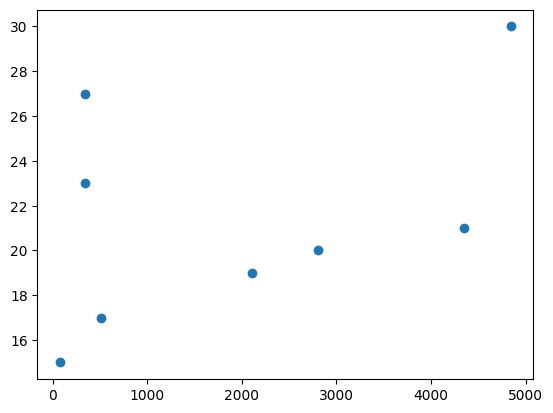

In [23]:
plt.scatter(pr, t_n)

In [24]:
np.mean(t_n)

21.5

In [25]:
'''average claim size for one disaster'''
one_pr = [int(p) / int(t) for p,t in zip(pr, t_n)]
print(one_pr)
np.mean(one_pr)

[5.066666666666666, 14.782608695652174, 206.85714285714286, 140.45, 12.444444444444445, 161.5, 110.73684210526316, 29.941176470588236]


85.22236015496969

2024-05-10 03:21:36.760 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.027278)
2024-05-10 03:21:36.775 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.02903)
2024-05-10 03:21:36.782 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.024778)
2024-05-10 03:21:36.796 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.028894)
2024-05-10 03:21:36.819 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.029022)
2024-05-10 03:21:36.824 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.028242)
2024-05-10 03:21:36.868 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.027278)
2024-05-10 03:21:36.907 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted e

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
exponpow,0.024634,1244.865698,1245.104023,inf,0.257440,0.578285
weibull_min,0.024755,1217.668808,1217.907133,inf,0.227389,0.723619
powerlaw,0.024778,1265.535470,1265.773795,inf,0.462084,0.043929
chi2,0.025255,1177.058308,1177.296632,inf,0.310685,0.348576
exponweib,0.025512,1296.580188,1296.897954,inf,0.293207,0.417931


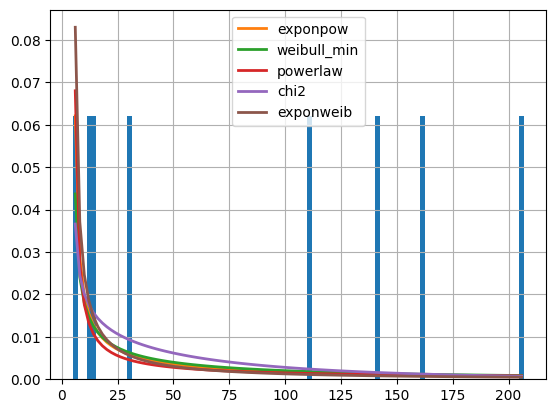

In [26]:
from fitter import Fitter, get_common_distributions


#Organize Data - from question
SR_y = pd.Series(one_pr, name="one_pr (Target Vector Distribution)")


# fitter
distributions_set = get_common_distributions()
distributions_set.extend(['arcsine', 'cosine', 'expon', 'weibull_max', 'weibull_min', 
                          'dweibull', 't', 'pareto', 'exponnorm', 'lognorm',
                          "norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"])  

f = Fitter(SR_y, distributions = distributions_set) 
f.fit()
f.summary()

In [27]:
f.fitted_param

{'expon': (5.066666666666666, 80.15569348830303),
 'norm': (85.22236015496969, 74.2072332764242),
 'powerlaw': (0.16096313440849647, 5.0666666666666655, 201.79047619047623),
 'rayleigh': (-40.38238831111727, 103.15829173597878),
 'cauchy': (45.09594955971241, 54.2265208769078),
 'uniform': (5.066666666666666, 201.7904761904762),
 'exponpow': (0.3169293696608979, 5.0666666666666655, 156.86049154819978),
 'cosine': (89.09197234043492, 59.32013016286106),
 'arcsine': (-16.436142205314837, 223.29328506245773),
 'pareto': (0.14374360431210523, 5.048955306012195, 0.017711360654470983),
 'lognorm': (3.6881261018678626, 5.066666192836818, 0.38323608547855914),
 'chi2': (1.3095923055666248, 5.0666666666666655, 47.008720009592025),
 'dweibull': (2.9041674031664346, 84.05674905412448, 78.07297167772052),
 'weibull_max': (0.18448496311003693, 206.8571428571429, 1.9110392836340613),
 'exponnorm': (0.24054515798986303, 67.86422911857807, 72.16162121781252),
 'gamma': (0.7721422817773667, 5.066666666

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


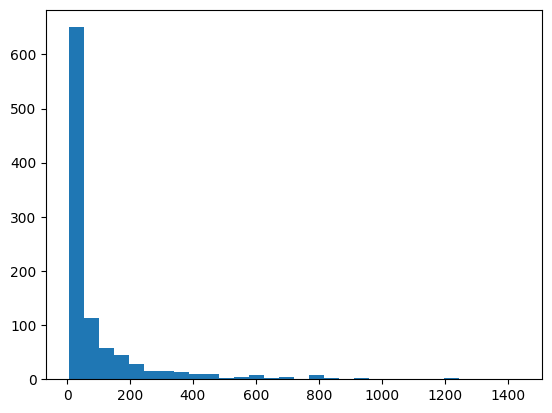

In [36]:
from scipy.stats import exponpow

r = exponpow.rvs(0.3169293696608979, 5.0666666666666655, 156.86049154819978, size =1000)

abs_r = []

for i in r:
    if i >= 0:
        abs_r.append(i)
    if i < 0:
        abs_r.append(0)
        
plt.hist(abs_r, bins=30, histtype="stepfilled")
#plt.set_xlim([x[0], x[-1]])
plt.legend(loc='best', frameon=False)
plt.show()

((array([-3.19758950e+00, -2.93237785e+00, -2.78437841e+00, -2.67999560e+00,
         -2.59855946e+00, -2.53139899e+00, -2.47402263e+00, -2.42379214e+00,
         -2.37902149e+00, -2.33856546e+00, -2.30160949e+00, -2.26755284e+00,
         -2.23593934e+00, -2.20641415e+00, -2.17869564e+00, -2.15255643e+00,
         -2.12781017e+00, -2.10430217e+00, -2.08190261e+00, -2.06050135e+00,
         -2.04000420e+00, -2.02032992e+00, -2.00140792e+00, -1.98317650e+00,
         -1.96558137e+00, -1.94857451e+00, -1.93211325e+00, -1.91615948e+00,
         -1.90067901e+00, -1.88564107e+00, -1.87101783e+00, -1.85678408e+00,
         -1.84291686e+00, -1.82939524e+00, -1.81620005e+00, -1.80331371e+00,
         -1.79072004e+00, -1.77840415e+00, -1.76635224e+00, -1.75455157e+00,
         -1.74299028e+00, -1.73165738e+00, -1.72054262e+00, -1.70963644e+00,
         -1.69892989e+00, -1.68841463e+00, -1.67808281e+00, -1.66792707e+00,
         -1.65794051e+00, -1.64811661e+00, -1.63844924e+00, -1.62893261e+00,

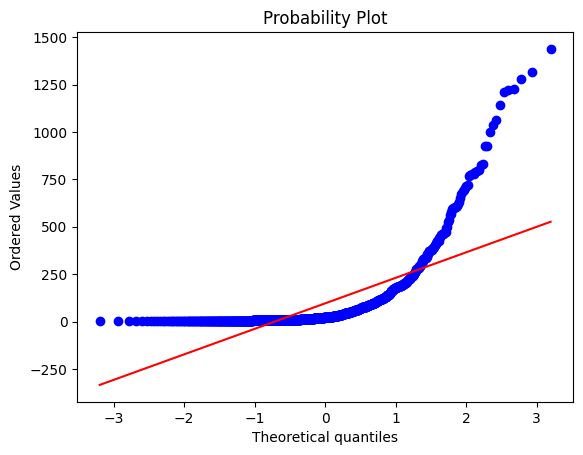

In [37]:
stats.probplot(abs_r, plot=plt)

In [38]:
claims = {}
for t in tqdm(years):
    claims_t = []
    for i in range(10000):
        rvs = poisson.rvs(21.5*t)*exponpow.rvs(0.3169293696608979, 5.0666666666666655, 156.86049154819978)
        if rvs >= 0:
            claims_t.append(rvs)
        if rvs < 0:
            claims_t.append(0)
        claims[f'X_{t}'] = claims_t

100%|███████████████████████████████████████████| 61/61 [00:34<00:00,  1.75it/s]


In [39]:
sorted_claims = {k: sorted(v) for k, v in claims.items()}

In [40]:
cdf_all = pd.DataFrame(sorted_claims)
cdf_all

,X_0.0,X_0.08333333333333333,X_0.16666666666666666,X_0.25,X_0.3333333333333333,X_0.4166666666666667,X_0.5,X_0.5833333333333334,X_0.6666666666666666,X_0.75,...,X_4.25,X_4.333333333333333,X_4.416666666666667,X_4.5,X_4.583333333333333,X_4.666666666666667,X_4.75,X_4.833333333333333,X_4.916666666666667,X_5.0
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.196920,16.281419,17.251758,...,283.742805,332.309663,324.370148,354.822913,346.748062,359.804020,338.233046,344.394466,356.105097,395.219932
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,10.141814,8.091965,25.370838,25.391130,...,314.140149,336.359869,343.521232,355.030957,350.871439,369.888642,367.118853,363.207945,372.877291,400.279322
2,0.0,0.000000,0.000000,0.000000,0.000000,5.067578,10.168139,15.202543,26.499387,30.402227,...,320.093672,343.542666,349.633988,362.659442,351.439886,390.150220,369.972829,386.934727,392.143004,403.553364
3,0.0,0.000000,0.000000,0.000000,0.000000,5.143444,10.415952,16.333613,26.673770,32.368083,...,330.750328,344.534176,352.493579,373.825504,354.690624,391.188715,370.025926,394.612230,407.477935,406.017785
4,0.0,0.000000,0.000000,0.000000,0.000000,10.133675,14.450763,16.753868,29.184114,35.472936,...,336.201323,346.870462,362.950364,374.961236,355.290261,392.635219,380.000863,395.324173,411.125629,410.455671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,5557.545583,7702.178073,11983.429973,17762.965656,17916.079150,22474.290035,29799.612796,25907.424060,29765.609778,...,178662.355845,167161.454828,194278.781832,205589.227037,199147.488085,186351.219401,188840.839156,199439.560590,180641.450675,199566.949786
9996,0.0,5673.060096,7835.792398,14658.593892,19978.769448,18291.002221,23246.429671,31152.890632,26148.288888,30051.815575,...,188239.402506,197073.157161,196618.970769,211792.348962,209030.271788,200243.859454,202476.568334,204496.737800,184328.058684,201829.186948
9997,0.0,6155.314089,8039.037952,14809.508972,24101.416207,23405.704163,23396.378741,32795.378689,28790.870168,33739.398229,...,190473.114241,198456.674799,199066.821463,213392.257396,218361.348989,204890.110091,202697.697519,218544.501859,187344.033787,206687.999655
9998,0.0,6939.720103,9772.367798,15800.696244,24409.686747,26710.369363,24357.789585,35019.681266,31044.282907,34096.687597,...,197719.317294,269191.386353,214195.528843,237054.863245,279529.297164,209395.555549,207211.618822,230209.439691,267979.016257,223188.059856


In [41]:
def integrand(x):
    return a

prob = []

for i in range(1,10001):
    prob.append(i/10000)

for i in years:
    cdf_all[f'prob_{i}'] = prob
    
for i in years:
    cdf_all[f'prob_{i}'][(cdf_all[f'X_{i}']==0)] = 0

n= -1
for i in years:
    n+=1
    cdf_all[f'rate_{i}'] = rate[n]

n= -1
for i in years:
    n+=1
    a = rate[n]
    cdf_all[f'discount_{i}'] = math.exp(-quad(integrand, 0, i)[0])

for i in years:
    cdf_all[f'V_{i}'] = cdf_all[f'discount_{i}']*cdf_all[f'prob_{i}']

/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_98621/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_98621/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_98621/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [42]:
X_0 = []
Y_0 = []
Z_0 = []

for i in years:
    for n in cdf_all[f'X_{i}'].tolist():
        X_0.append(n)

for i in years:
    for n in cdf_all[f'V_{i}'].tolist():
        Y_0.append(n)

for i in years:
    for n in range(10000):
        Z_0.append(i)


X = X_0
Y = Y_0
Z = Z_0

plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),np.linspace(np.min(Y),np.max(Y),10))
plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')


@interact(elev=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False), azim=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False))
def plot_3d(elev, azim):
    #Figure settings
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection='3d')
    #Display 3D graph
    ax.plot_surface(plotx,plotz,ploty,cstride=1,rstride=1,cmap='viridis')
    ax.set_xlabel('D (критический уровень триггера)') 
    ax.set_ylabel('T (срок, лет)') 
    ax.set_zlabel('V (Стоимость) ')
    
    #Set the initial value of the viewing direction of the 3D graph
    ax.view_init(elev=elev, azim=azim)
    plt.show()

interactive(children=(IntSlider(value=30, continuous_update=False, description='elev', max=180, min=-180, step…

In [43]:
# Expected loss 2%
s_2 = round(((1/cdf_all['V_2.0'][9800])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9800])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9800])**(1/4)-1-0.1192)*100, 3)

print('Expected loss 2%')
print(round(cdf_all['X_2.0'][9800], 3), round(cdf_all['X_3.0'][9800], 3), round(cdf_all['X_4.0'][9800], 3))
print(round(cdf_all['V_2.0'][9800], 4), round(cdf_all['V_3.0'][9800], 4), round(cdf_all['V_4.0'][9800], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 2,5%
s_2 = round(((1/cdf_all['V_2.0'][9750])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9750])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9750])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 2,5%')
print(round(cdf_all['X_2.0'][9750], 3), round(cdf_all['X_3.0'][9750], 3), round(cdf_all['X_4.0'][9750], 3))
print(round(cdf_all['V_2.0'][9750], 4), round(cdf_all['V_3.0'][9750], 4), round(cdf_all['V_4.0'][9750], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 3%
s_2 = round(((1/cdf_all['V_2.0'][9700])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9700])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9700])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 3%')
print(round(cdf_all['X_2.0'][9700], 3), round(cdf_all['X_3.0'][9700], 3), round(cdf_all['X_4.0'][9700], 3))
print(round(cdf_all['V_2.0'][9700], 4), round(cdf_all['V_3.0'][9700], 4), round(cdf_all['V_4.0'][9700], 4))
print(s_2, s_3, s_4)

Expected loss 2%
29390.97 42102.434 61207.637
0.7581 0.6672 0.5875
2.301 2.279 2.301

Expected loss 2,5%
26705.362 38684.95 55010.833
0.7542 0.6638 0.5845
2.595 2.475 2.447

Expected loss 3%
25021.021 35764.433 50891.935
0.7504 0.6604 0.5815
2.892 2.671 2.594
